### Import modules

In [1]:
import os
import torch
import torch.nn as nn
import lightning as L
from lightning.pytorch.callbacks import (
    ModelSummary,
    ModelCheckpoint,
    LearningRateMonitor,
)
from lightning.pytorch.tuner import Tuner

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
from models.yolo import YOLOv3
from utils.data import PascalDataModule
from utils.gradcam import plot_gradcam
from utils.loss import YoloLoss
import config

### Configuration Parameters

In [4]:
batch_size = config.BATCH_SIZE
shuffle = config.SHUFFLE
num_workers = os.cpu_count() - 1
learning_rate = config.LEARNING_RATE
epochs = config.NUM_EPOCHS
num_classes = config.NUM_CLASSES
num_devices = config.DEVICE_COUNT

### Import the Datamodule & Initialize

In [5]:
datamodule = PascalDataModule(
    train_csv_path=f"{config.DATASET}/train.csv",
    test_csv_path=f"{config.DATASET}/test.csv",
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
)
datamodule.setup()

### Initialize Model & Trainer

In [6]:
maxlr = learning_rate
scheduler_steps = len(datamodule.train_dataloader())

callbacks = [
    ModelSummary(max_depth=10),
    ModelCheckpoint(
        dirpath="model_checkpoints",
        filename="yolov3_{epoch}",
        monitor="train_loss",
        mode="min",
        save_last=True,
    ),
]

model = YOLOv3(
    in_channels=3,
    num_classes=num_classes,
    epochs=epochs,
    loss_fn=YoloLoss,
    datamodule=datamodule,
    learning_rate=learning_rate,
    maxlr=maxlr,
    scheduler_steps=scheduler_steps,
    device_count=num_devices,
)

trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    num_nodes=1,
    max_epochs=epochs,
    callbacks=callbacks,
    precision="16-mixed",
    check_val_every_n_epoch=10,
    num_sanity_val_steps=0,
    enable_checkpointing=True,
)

Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Find the best learning rate

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/ravi.naik/learning/era/s13/exp/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007079457843841378
Restoring states from the checkpoint path at /home/ravi.naik/learning/era/s13/exp/.lr_find_b9963b1d-74a7-4548-9605-200c9c3f2988.ckpt
Restored all states from the checkpoint at /home/ravi.naik/learning/era/s13/exp/.lr_find_b9963b1d-74a7-4548-9605-200c9c3f2988.ckpt


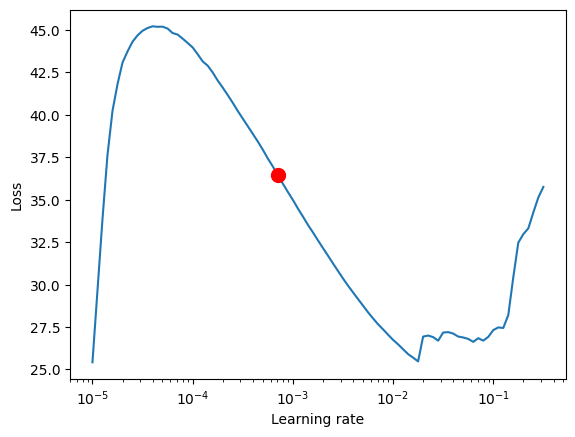

In [7]:
tuner = Tuner(trainer)

lr_finder = tuner.lr_find(
    model=model, min_lr=1e-5, train_dataloaders=datamodule.train_dataloader()
)
maxlr = lr_finder.suggestion()
fig = lr_finder.plot(suggest=True)

In [8]:
maxlr

0.0007079457843841378

### Updated the optimum LR & Begin training

In [9]:
model.learning_rate = maxlr
model.maxlr = maxlr

trainer.fit(model=model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

    | Name                       | Type              | Params
-------------------------------------------------------------------
0   | loss_fn                    | YoloLoss          | 0     
1   | loss_fn.mse                | MSELoss           | 0     
2   | loss_fn.bce                | BCEWithLogitsLoss | 0     
3   | loss_fn.entropy            | CrossEntropyLoss  | 0     
4   | loss_fn.sigmoid            | Sigmoid           | 0     
5   | layers                     | ModuleList        | 61.6 M
6   | layers.0                   | CNNBlock          | 928   
7   | layers.0.conv              | Conv2d            | 864   
8   | layers.0.bn                | BatchNorm2d       | 64    
9   | layers.0.leaky             | LeakyReLU         | 0     
10  | layers.1                   | CNNBlock          | 18.6 K
11  | layers.1.conv              | Conv2d            | 18.4 K
12  | layers.1.bn                | BatchNorm2d       | 128   
13  | layers.1.leak

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


### Testing

In [ ]:
# Stopping testing after 1 batch, since the testing is performed
# on entire dataset

In [10]:
trainer.test(model=model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]


100%|██████████| 39/39 [03:04<00:00,  4.73s/it]


Class accuracy is: 81.288651%
No obj accuracy is: 97.950813%
Obj accuracy is: 75.985947%



  0%|          | 0/39 [00:03<?, ?it/s]


In [11]:
from utils.utils import check_class_accuracy

In [13]:
class_acc, noobj_acc, obj_acc = check_class_accuracy(
    model=model,
    loader=datamodule.test_dataloader(),
    threshold=config.CONF_THRESHOLD)


100%|██████████| 39/39 [03:17<00:00,  5.07s/it]

Class accuracy is: 81.601883%
No obj accuracy is: 97.991463%
Obj accuracy is: 75.976616%


### MAP Calculation

In [14]:
from utils.utils import get_evaluation_bboxes, mean_average_precision

In [15]:
pred_boxes, true_boxes = get_evaluation_bboxes(
    datamodule.test_dataloader(),
    model,
    iou_threshold=config.NMS_IOU_THRESH,
    anchors=config.ANCHORS,
    threshold=config.CONF_THRESHOLD,
)
mapval = mean_average_precision(
    pred_boxes,
    true_boxes,
    iou_threshold=config.MAP_IOU_THRESH,
    box_format="midpoint",
    num_classes=config.NUM_CLASSES,
)
print(f"MAP: {mapval.item()}")


100%|██████████| 39/39 [27:46<00:00, 42.74s/it]


MAP: 0.43667954206466675


### Save last Checkpoint

In [16]:
trainer.save_checkpoint("model.ckpt")

### Visualize Results + Mosaic Samples

In [18]:
from utils.utils import plot_couple_examples

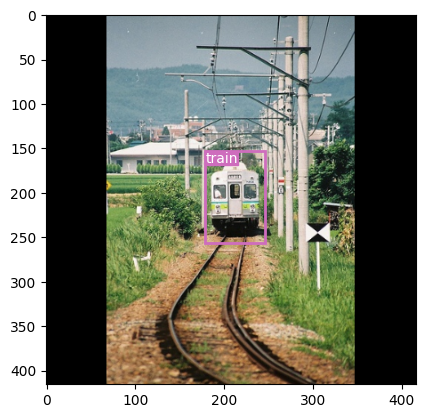

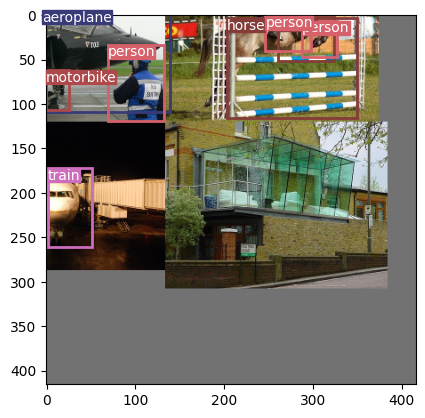

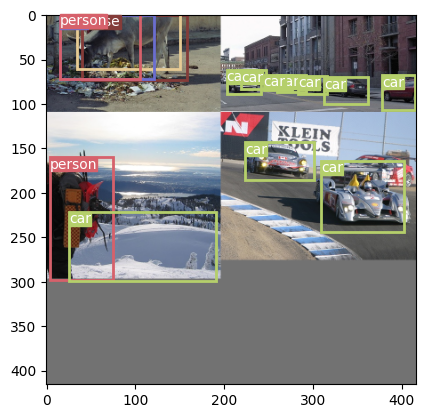

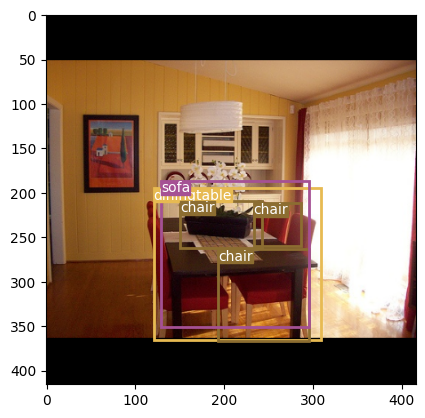

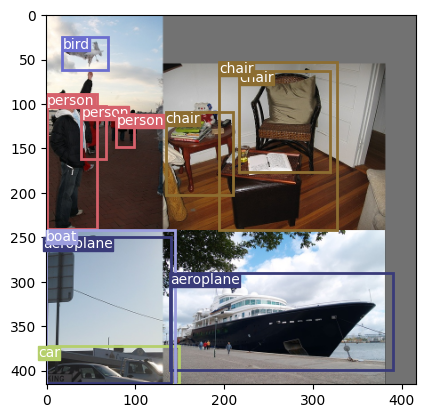

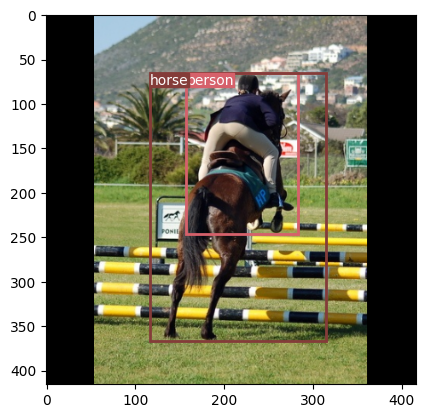

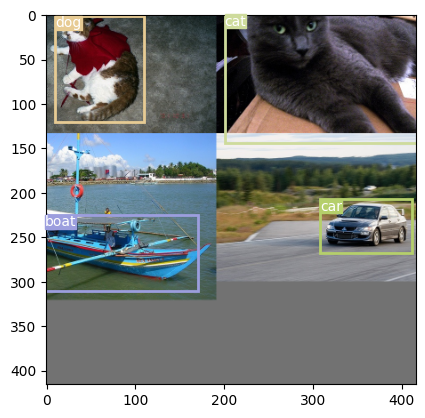

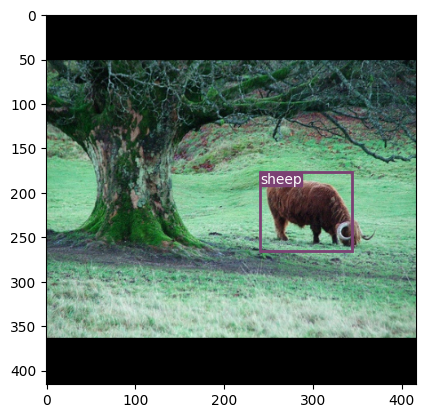

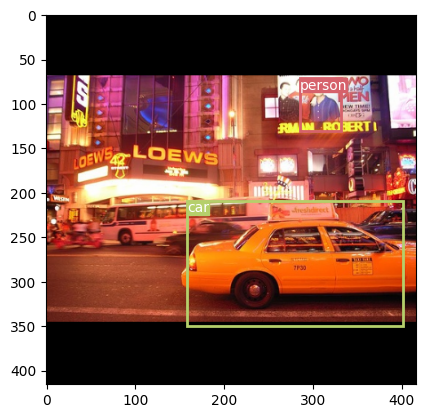

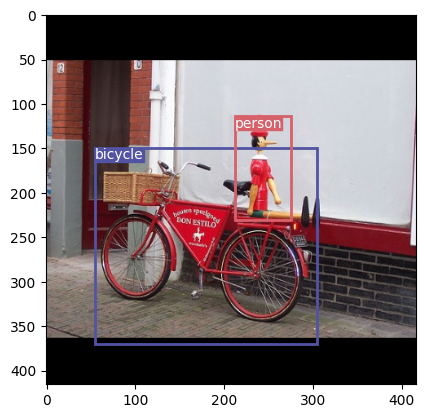

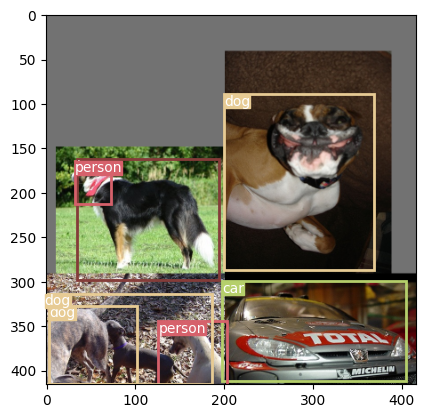

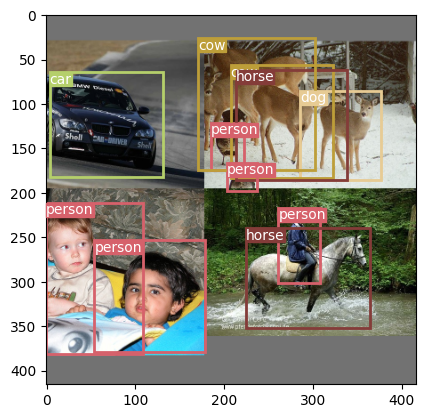

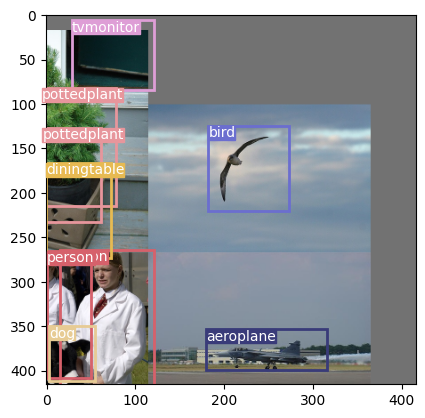

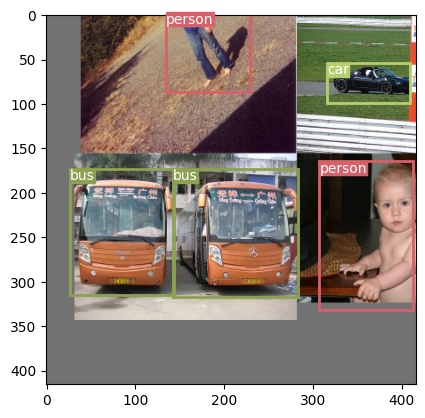

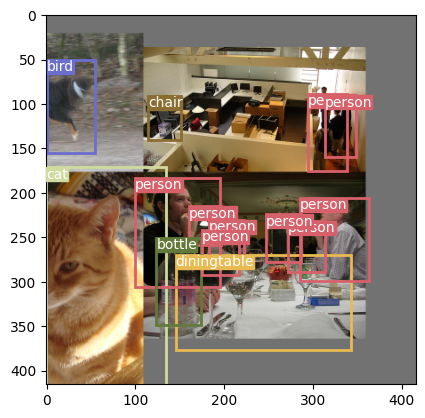

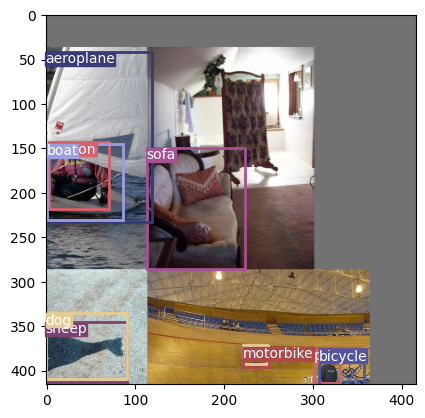

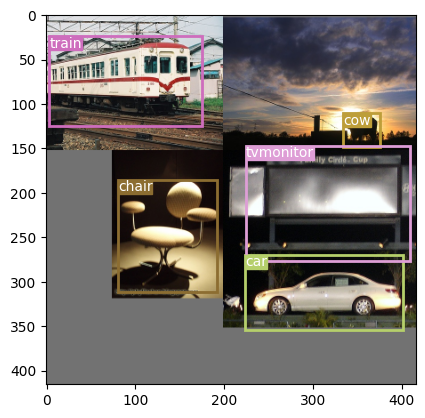

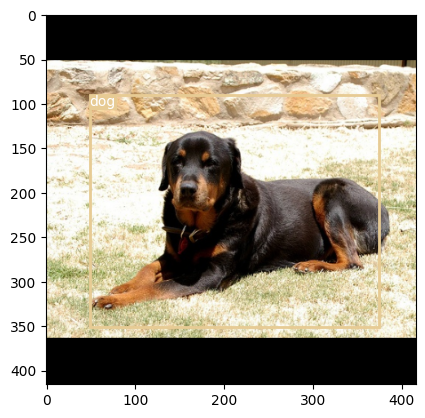

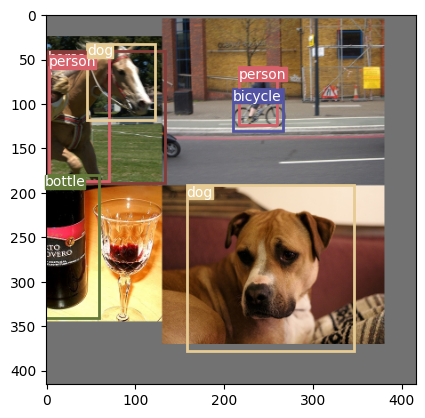

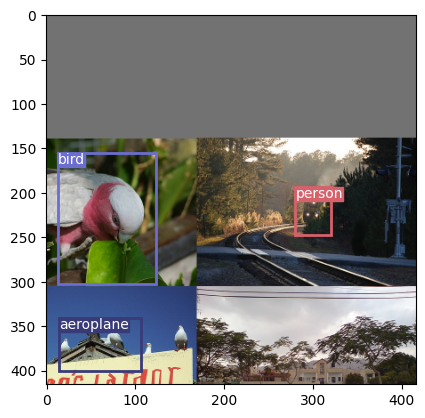

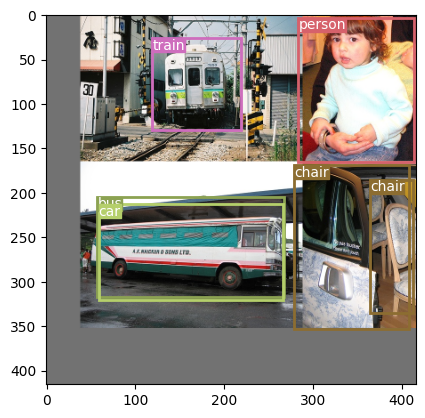

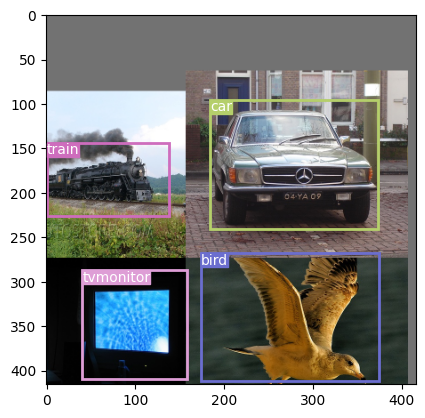

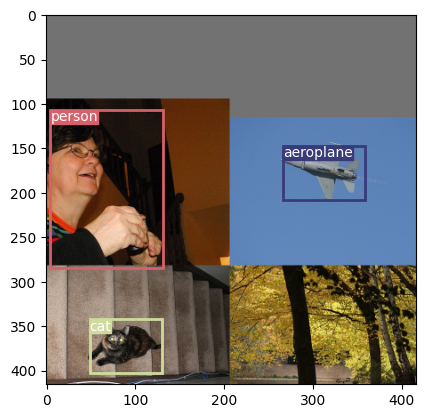

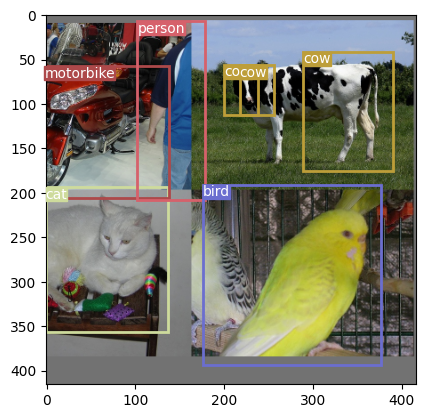

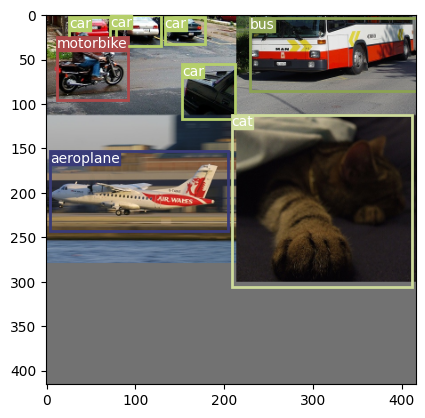

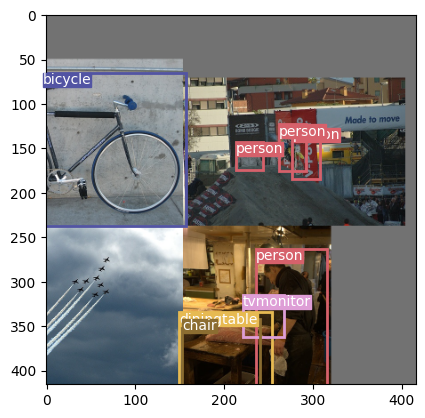

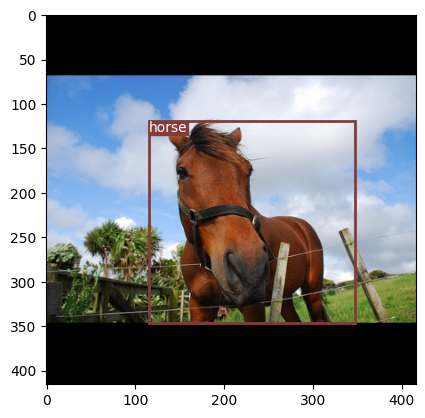

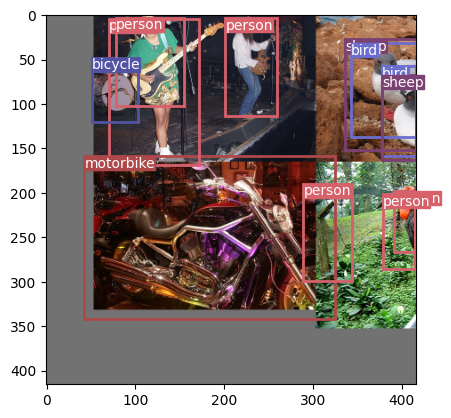

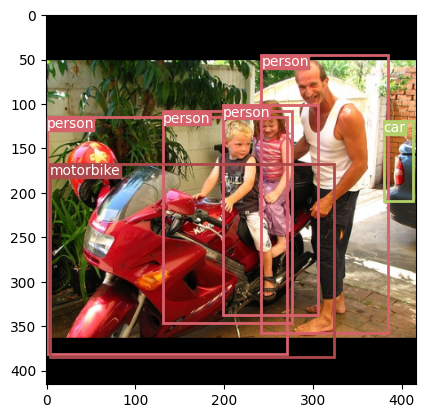

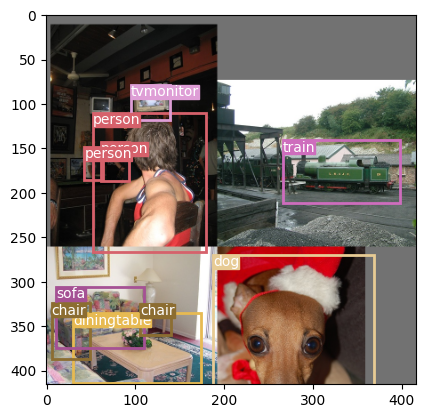

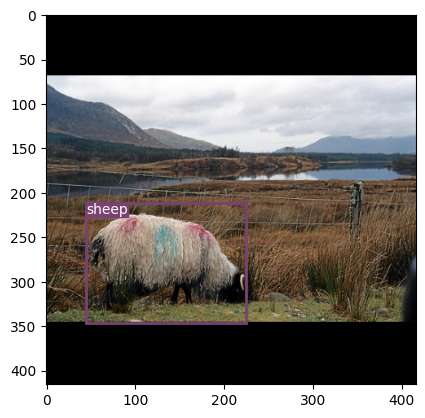

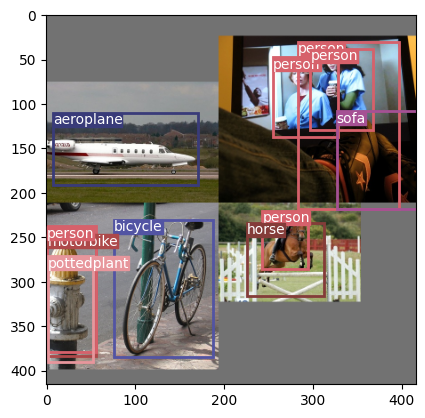

In [20]:
plot_couple_examples(model, datamodule.test_dataloader(), 0.6, 0.5, model.scaled_anchors)

### Generate Gradcam representation

In [21]:
from utils.gradcam import plot_gradcam

In [27]:
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import matplotlib.pyplot as plt

In [33]:
inv_normalize = None
targets = None
transparency = 0.60
number_of_samples = 10

In [31]:
target_layers = [model.layers[-1]]

In [34]:
data = next(iter(datamodule.test_dataloader()))[0][:10]

In [35]:
rows = 2
cols = 5

In [38]:
data[0].unsqueeze(0).shape

torch.Size([1, 3, 416, 416])

AttributeError: 'list' object has no attribute 'cpu'

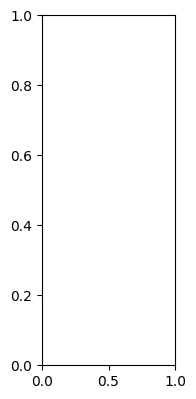

In [39]:
fig = plt.figure(figsize=(10,10))

cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
for i in range(number_of_samples):
        plt.subplot(rows, cols, i + 1)
        input_tensor = data[i]

        # Get the activations of the layer for the images
        grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        # Get back the original image
        img = input_tensor.squeeze(0).to('cpu')
        if inv_normalize is not None:
            img = inv_normalize(img)
        rgb_img = np.transpose(img, (1, 2, 0))
        rgb_img = rgb_img.numpy()

        # Mix the activations on the original image
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=transparency)

        # Display the images on the plot
        plt.imshow(visualization)
        # plt.title(f"Label: {classes[data[i][1].item()]} \n Prediction: {classes[data[i][2].item()]}")
        plt.xticks([])
        plt.yticks([])